# М1 Линейные классификаторы
    выполнил Сергей Харитонов МИВТ-221

# Задание
используя разбиение в на 2 кластера в задании Б1, построить дискриминантную функцию Фишер


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Константы для визуализации кластеров
CLUSTERS = [
    # (color, sign)
    ('lightgreen', 's'),
    ('lightblue', 'v'),
]

In [2]:
# Загрузка данных в память
data = pd.read_csv('clustered_data.csv')

# Разделение на тестовую и тренировочную выборки
test_count = 5000
border = len(data)-test_count

test_data = data[border:]
data = data[:border]

# Фильтруем по типам кластеров и убираем колонку с метками кластеров
first_cluster = data[data.cluster == 0][['car_prob', 'customer_psy']]
second_cluster = data[data.cluster == 1][['car_prob', 'customer_psy']]

print(first_cluster)
print(second_cluster)

print(f'Количество записей: {len(data)}')
print(f'Первого класса: {len(first_cluster)}')
print(f'Второго класса: {len(second_cluster)}')


       car_prob  customer_psy
4             7            10
8             5             7
13            6             9
15            7             7
16            5             9
...         ...           ...
34982         1            10
34987         8             4
34990         8             9
34995         9             7
34996         5             6

[12480 rows x 2 columns]
       car_prob  customer_psy
0             1             2
1             3             5
2             1             3
3             2             2
5             1             2
...         ...           ...
34993         2             2
34994         2             7
34997         3             3
34998         1             2
34999         5             4

[22520 rows x 2 columns]
Количество записей: 35000
Первого класса: 12480
Второго класса: 22520


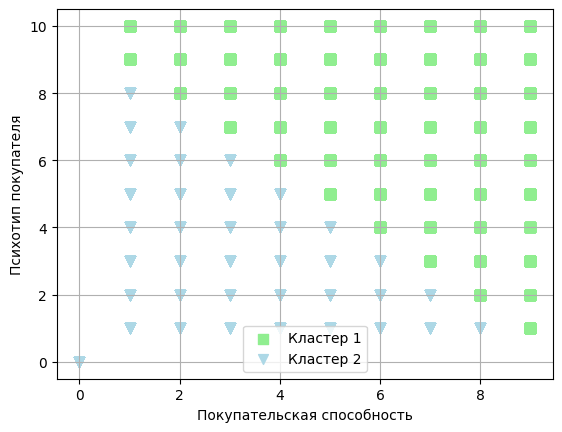

In [3]:
# Визуализация
def show_data():
    for index, cluster in enumerate([first_cluster, second_cluster]):
        color, sign = CLUSTERS[index]
        plt.scatter(
            cluster['car_prob'],
            cluster['customer_psy'],
            s=50,
            marker=sign,
            c=color,
            label=f'Кластер {index + 1}'
        )
    plt.xlabel('Покупательская способность')
    plt.ylabel('Психотип покупателя')
    plt.legend()
    plt.grid()


show_data()

In [4]:
#вычисляем ковариационную матрицу
A = data[['car_prob', 'customer_psy']].cov()
#вычисляем обратную к ковариационной
B = np.linalg.inv(A)

print(A)
print(B)

              car_prob  customer_psy
car_prob      6.653465      2.661634
customer_psy  2.661634      6.191977
[[ 0.18150943 -0.0780222 ]
 [-0.0780222   0.19503732]]


In [5]:
#вычисление векторов средних для каждого класса
mean_1 = first_cluster.mean()
mean_2 = second_cluster.mean()
print(mean_1)
print(mean_2)

car_prob        6.000481
customer_psy    7.108333
dtype: float64
car_prob        2.104485
customer_psy    3.279751
dtype: float64


In [6]:
#вектор разности средних
m = mean_1 - mean_2
print(m)

car_prob        3.895996
customer_psy    3.828582
dtype: float64


In [7]:
#коэффициенты функции Фишера
a = B.dot(m)
print(a)

[0.40844559 0.44274219]


In [8]:
#Функция Фишера: z=0.4x+0.44y
#вычисляем значения функции Фишера в центрах классов
e1 = a.dot(mean_1)
e2 = a.dot(mean_2)
print(e1)
print(e2)

5.598028975898711
2.31165186670246


In [9]:
#вычисляем порог а_0
a_0 = (e1 + e2) / 2
print(a_0)

3.9548404213005854


In [10]:
#визуализация: прямая 0.4x+0.44y=3.95, т.е. y=(-0.4x + 3.95) / 0.44
def F(x):
    return (-a[0] * x + a_0) / a[1]
print(a[0], a[1], a_0)

0.4084455878684943 0.4427421918804204 3.9548404213005854


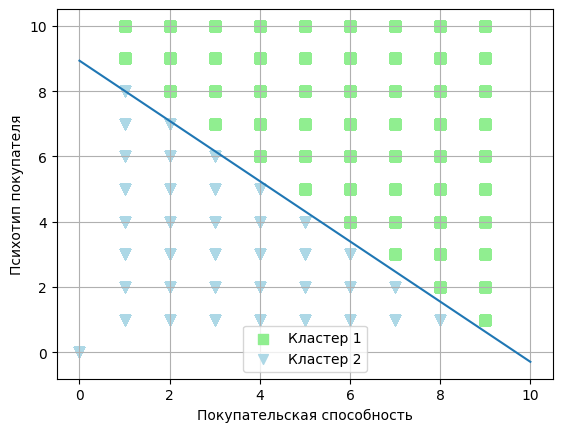

In [11]:
show_data()

Xs = [0.0, 10.0]
#Значения дискриминантной функции фишера в точках
Ys = list(map(F, Xs))
#рисую прямую
plt.plot(Xs, Ys)
plt.show()

In [12]:
# Проверка качества
def F_clussification(row):
    return 0 if a.dot(row[1]) > a_0 else 1

clussified_data = data.assign(
    F_clusters = list(
        map(
            F_clussification,
            data[['car_prob', 'customer_psy']].iterrows()
        )
    )
)
clussified_test_data = test_data.assign(
    F_clusters = list(
        map(
            F_clussification,
            test_data[['car_prob', 'customer_psy']].iterrows()
        )
    )
)

print(clussified_data)
print(clussified_test_data)

       car_prob  customer_psy  cluster  F_clusters
0             1             2        1           1
1             3             5        1           1
2             1             3        1           1
3             2             2        1           1
4             7            10        0           0
...         ...           ...      ...         ...
34995         9             7        0           0
34996         5             6        0           0
34997         3             3        1           1
34998         1             2        1           1
34999         5             4        1           1

[35000 rows x 4 columns]
       car_prob  customer_psy  cluster  F_clusters
35000         3             5        1           1
35001         2             2        1           1
35002         2             2        1           1
35003         2             3        1           1
35004         1             3        1           1
...         ...           ...      ...         ...
39995

In [13]:
def count_delta(_data):
    return sum(
        map(
            lambda row: 1 if row[1]['cluster'] != row[1]['F_clusters'] else 0,
            clussified_test_data.iterrows()
        )
    )

print(f'Количество ошибок на тренировочной выборке: {count_delta(clussified_data)}')
print(f'Количество ошибок на тестовой выборке: {count_delta(clussified_test_data)}')

Количество ошибок на тренировочной выборке: 0
Количество ошибок на тестовой выборке: 0


# Вывод
Исходя из рещультатов классификации следует,что дискриминантная функция Фишера была найдена верно.
